In [6]:
import numpy as np
import pandas as pd
import csv
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedGroupKFold

In [7]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [8]:
from point_net import PointNetClassHead
from point_net_loss import PointNetRegressionLoss
from utils import normalize_point_cloud, find_surface_indices

In [15]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import os
import warnings
warnings.filterwarnings("ignore")

In [16]:
REGION_LABEL = 4 # Name:Left-Lateral-Ventricle
save_dir = 'Region_' + str(REGION_LABEL) + '_models'
os.makedirs(save_dir, exist_ok=True)

NUM_POINTS = 8000
GLOBAL_FEATS = 256

BATCH_SIZE = 36
NUM_CLASSES = 1
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cpu


In [17]:
point_clouds_info = pd.read_csv('point_Clouds_info.csv');
dataI = pd.read_csv('dataI_with_stage.csv') ; dataI = dataI.drop('Unnamed: 0', axis = 1)
dataP = pd.read_csv('dataP_with_stage.csv') ; dataP = dataP.drop('Unnamed: 0', axis = 1)
dataTrack = pd.read_csv('dataTrack_with_stage.csv') ; dataTrack = dataTrack.drop('Unnamed: 0', axis = 1)
dataP['subjid'] = dataP['subjid'].astype(str)  # so that we can work with sklearn group split
dataSet  = pd.concat([dataI, dataP, dataTrack])
print(dataSet.shape)
patients = dataSet.loc[dataSet['group'] != 'control']
patients.reset_index(drop=True , inplace = True)
print(patients.shape)

(4407, 308)
(2932, 308)


In [ ]:
patients['Disease_Stage'] = patients['Disease_Stage'].apply(lambda x: int(x[6]) if not x.startswith('Error') else np.NaN)
patients = patients[~np.isnan(patients['Disease_Stage'])] # Drop empty rows (where 'error' was the prefix)
print(patients.shape)
numeric_columns = patients.select_dtypes(include='number').columns
patients.loc[:,numeric_columns] = pd.DataFrame(imputer.fit_transform(patients[numeric_columns]), columns=numeric_columns)
patients.reset_index(drop=True)
print(patients.shape)
patients['Disease_Stage'] = patients['Disease_Stage'].round(0).astype(int).astype(str)

(2932, 308)
(2932, 308)


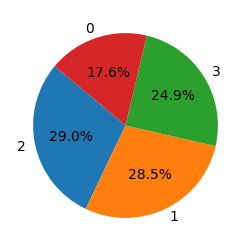

In [19]:
# Get value counts of 'cohort' column
cohort_counts = patients['Disease_Stage'].value_counts()
plt.figure(figsize=(3, 3))
plt.pie(cohort_counts, labels=cohort_counts.index, autopct='%1.1f%%', startangle=140)
plt.show()

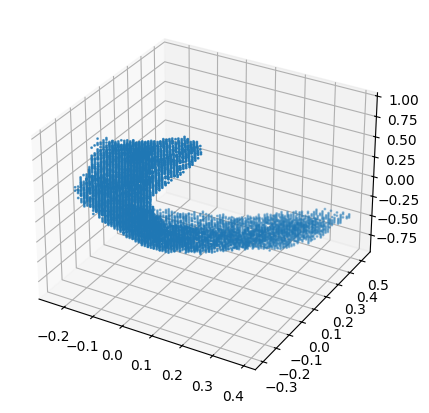

In [23]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(P[0], P[1], P[2] , s= 1)

### Classes and Methods

In [24]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subject_row = self.data.iloc[idx]
        disease_stage = subject_row['Disease_Stage']
        target = subject_row['PIN']
        
        path = subject_row['identifier']

        point_clouds_row = point_clouds_info.loc[point_clouds_info['identifier'] == path]
        
        index = int(point_clouds_row['index'])
        
        n = int(point_clouds_row[f'n_{REGION_LABEL}'])
        P = pd.read_csv(f'Point_clouds/{index}/region{REGION_LABEL}.csv').to_numpy()

        if NUM_POINTS < n:
            sampled_surface_indices = np.random.choice(n, size=NUM_POINTS, replace=False)
        else:
            sampled_surface_indices = np.random.choice(n, size=NUM_POINTS, replace=True)
        P = P[:,sampled_surface_indices]
        
        return torch.Tensor(P), torch.tensor(target, dtype = torch.float), disease_stage

In [25]:
skf_gen = StratifiedGroupKFold(n_splits=6, shuffle=False).split(patients, y=patients['Disease_Stage'] , groups= patients['subjid'])
train_ind , not_train_ind = next(iter(skf_gen))
X_train = patients.iloc[train_ind] 
X_not_train = patients.iloc[not_train_ind]

skf_gen = StratifiedGroupKFold(n_splits=2, shuffle=False).split(X_not_train, y=X_not_train['Disease_Stage'] , groups= X_not_train['subjid'])
test_ind , valid_ind = next(iter(skf_gen))
X_test = X_not_train.iloc[test_ind] 
X_valid = X_not_train.iloc[valid_ind]

print(patients.shape)
print(X_train.shape , X_not_train.shape , X_test.shape , X_valid.shape)

train_dataset = CustomDataset(X_train)
valid_dataset = CustomDataset(X_valid)
test_dataset = CustomDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

(2932, 308)
(2443, 308) (489, 308) (244, 308) (245, 308)


In [26]:
classifier = PointNetClassHead (num_points = NUM_POINTS , num_global_feats = GLOBAL_FEATS, k = NUM_CLASSES)
classifier = classifier.to(DEVICE)

In [27]:
classifier.load_state_dict(torch.load(save_dir + '/cls_model_18_PIN.pth', map_location = torch.device(DEVICE)))

<All keys matched successfully>

In [28]:
EPOCHS = 100
LR = 0.001
optimizer = optim.Adam(classifier.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, 
                                              step_size_up=2000, cycle_momentum=False)
criterion = PointNetRegressionLoss(reg_weight = 0.001)

In [29]:
def train_test(classifier, dataloader, num_batch, epoch, split):
    print(f'Epoch = {epoch} ,  Phase: {split}')
    ''' Function to train or test the model '''
    _loss = []
    for i, (points, targets , _) in enumerate(dataloader, 0):
        points = points.to(DEVICE)
        targets = targets.squeeze().to(DEVICE)
        # zero gradients
        optimizer.zero_grad() 
        # get predicted class logits
        preds, _ , A = classifier(points)
        # get loss and perform backprop
        loss = criterion(preds, targets , A) 
        # update epoch loss 
        _loss.append(loss.item())
        # print(f'[iteration: {i} from {num_batch}]   MSE loss: {loss}')

        if split == 'train':
            loss.backward()
            optimizer.step()
            scheduler.step()
  
        # Save loss in CSV file after each iteration
        with open(save_dir + '/records_' + split + '.csv', 'a', newline='') as csvfile:
            fieldnames = ['Epoch', 'Iteration', 'Loss' ]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames) 
            if csvfile.tell() == 0:  # Check if file is empty
                writer.writeheader()   
            writer.writerow({'Epoch': epoch + 1, 'Iteration': i, 'Loss': loss.item()})
            
    epoch_loss = np.mean(_loss)
    print(f'\n Epoch: {epoch} - {split} Loss: {epoch_loss:.4f} \n')
    return epoch_loss

### Start training

In [30]:
num_train_batch = int(np.ceil(len(train_dataset)/BATCH_SIZE))
print('num_train_batch' , num_train_batch)

num_valid_batch = int(np.ceil(len(valid_dataset)/BATCH_SIZE))
print('num_valid_batch' , num_valid_batch)

num_train_batch 68
num_valid_batch 7


In [ ]:
# lists to store metrics (loss, accuracy, mcc)
train_metrics = []
valid_metrics = []

# TRAIN ON EPOCHS
for epoch in range(19,EPOCHS):
    ## train loop
    classifier = classifier.train()
    # train
    _train_metrics = train_test(classifier, train_loader, num_train_batch, epoch, split='train')
    train_metrics.append(_train_metrics)
    torch.save(classifier.state_dict(), save_dir + '/cls_model_%d_PIN.pth' % epoch)

    ## validation loop
    with torch.no_grad():
        # place model in evaluation mode
        classifier = classifier.eval()
        # validate
        _valid_metrics = train_test(classifier, valid_loader, num_valid_batch, epoch, split='valid')
        valid_metrics.append(_valid_metrics)

    with open(save_dir + '/epochs.csv', 'a', newline='') as csvfile:
        fieldnames = ['Epoch', 'Train_Loss', 'Valid_Loss' ]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if csvfile.tell() == 0:  # Check if file is empty
            writer.writeheader()
        writer.writerow({'Epoch': epoch + 1, 'Train_Loss': _train_metrics, 'Valid_Loss': _valid_metrics})

#### Evaluation

In [ ]:
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [ ]:
global_features_array = []
critical_indexes_array = []
disease_stage_array = []

for i, (points, targets, stage) in enumerate(tqdm(test_loader, desc='Processing test data')):
    points = points.to(DEVICE)
    targets = targets.squeeze().to(DEVICE)
    
    # Pass the points through the backbone of the PointNet
    global_features, critical_indexes , _ = classifier.backbone(points)
    preds, _ , _ = classifier(points)
    
    plt.scatter(targets.cpu().data.numpy(), preds.cpu().data.numpy())
   
    # Append the global features to the array
    global_features_array.append(global_features.cpu().data.numpy())
    critical_indexes_array.append(critical_indexes.cpu().data.numpy())
    disease_stage_array.append(stage)

# Convert the list of arrays to a single numpy array
global_features_array = np.concatenate(global_features_array, axis=0)
critical_indexes_array = np.concatenate(critical_indexes_array, axis=0)
disease_stage_array = np.concatenate(disease_stage_array, axis=0)

abline(slope = 1, intercept = 0)

In [ ]:
global_features_array.shape

In [ ]:
# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the global features
tsne_result = tsne.fit_transform(global_features_array)

# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])

# Concatenate the t-SNE results with the disease stage column
tsne_df['Disease_Stage'] = disease_stage_array

# Plot t-SNE results with seaborn
sns.scatterplot(x='TSNE1', y='TSNE2', hue = 'Disease_Stage' , palette = 'cool',
                data=tsne_df , hue_order=['Stage 0', 'Stage 1','Stage 2','Stage 3'] )
plt.title('t-SNE Visualization of Global Features with Disease Stage')
plt.show()

In [ ]:

# Assuming classifier is your PointNet model
classifier.eval()

for i, (points, targets, stage) in enumerate(tqdm(test_loader, desc='Processing test data')):
    points_device = points.to(DEVICE)
    # Pass points through your classifier
    pred , critical_indexes, _ = classifier(points_device)
    
    # Iterate over each point cloud in the batch
    for j in range(points.size(0)):
        # Create a new plot for each point cloud
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111, projection='3d')
        
        # Get the points for the current point cloud
        current_points = points[j].cpu().numpy()
        
        # Plot the point cloud
        ax.scatter(current_points[0 , :], current_points[1 , :], current_points[2 , :], s=1)
               
        # Plot critical points
        critical_points = current_points[: ,critical_indexes[j].cpu().numpy()]
        ax.scatter(critical_points[0 , : ], critical_points[1, :], critical_points[2 , :], c='r', s=3)
        ax.set_title(f'Target: {targets[j]}, Stage: {stage[j]} , Pred: {pred[j].cpu().item()}')

        # Save the plot as a PDF file
        save_path = os.path.join(save_dir, f'point_cloud_{i}_{j}.pdf')
        plt.savefig(save_path)
        plt.close()  # Close the plot to free memory
        
print("Plots saved successfully.")